# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [89]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_roc_curve
from skopt import BayesSearchCV
from skopt.space import Real, Integer
%matplotlib inline

sns.set(style="darkgrid")
from  matplotlib.ticker import PercentFormatter
plt.rcParams['figure.figsize'] = [10, 7]
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
features_summary = pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx")
features_summary.head()

,Information level,Attribute,Description,Additional notes,new_column_name,type,drop,drop comment,of_interest,to_dummy
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...,AGER_TYP,C,1.0,NaN,1.0,1.0
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...,EST_AGE,C-O,NaN,NaN,1.0,NaN
2,NaN,ANREDE_KZ,gender,NaN,GENDER,C,NaN,NaN,1.0,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi...",CUSTOMER_JOURNEY_TYPOLOGY,C,NaN,NaN,1.0,1.0
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...,FIN_TYPE_MINIMALIST,C-O,NaN,NaN,NaN,NaN


In [3]:
feature_values = pd.read_excel("DIAS Attributes - Values 2017.xlsx")
feature_values["new_column_name"] = feature_values["new_column_name"].fillna(method="ffill")
feature_values["Meaning"] = feature_values["Meaning"].fillna(method="ffill")
feature_values.head()

,Attribute,Description,Value,Meaning,new_column_name
0,AGER_TYP,best-ager typology,-1,unknown,AGER_TYP
1,NaN,NaN,0,no classification possible,AGER_TYP
2,NaN,NaN,1,passive elderly,AGER_TYP
3,NaN,NaN,2,cultural elderly,AGER_TYP
4,NaN,NaN,3,experience-driven elderly,AGER_TYP


In [9]:
def get_values_for_feature(feature):
    """ 
    returns a dictionary with possible values of the feature as keys and their
    corresponding meaning as value
    """
    feature_subdf = feature_values.query(
        "new_column_name == '{}'".format(feature)
    )
    description = feature_subdf["Description"].iloc[0]
    value_meanings = feature_subdf.set_index("Value")["Meaning"]
    value_meanings =  { 
        int(val) if val.lstrip("-").isnumeric() else val:mean 
     for value, meaning in value_meanings.iteritems() 
     for val, mean in list(
         zip(
             str(value).split(", "), 
             [meaning] * len(str(value).split(", "))
         )
     )
    }
    value_meanings[-1] = "unknown"
    if features_summary[features_summary.new_column_name==feature]\
        ["type"].iloc[0] == "N":
        value_meanings = {}
    return description, value_meanings

In [63]:
def clean_df(
    df, 
    drop_columns_not_in_feature_excel=True, 
    drop_columns_indicated_as_drop=True, 
    extra_cols_to_drop=None
    ):
    """
    This function cleans the dataset inplace by dropping some columns, 
    renaming others and unifying nan or missing values it is possible 
    to set it so that only some columns are dropped or some extra 
    columns are dropped.
    
    params:
    -------
        - df: DataFrame to be cleaned
        - drop_columns_not_in_feature_excel: bool, indicator for 
        dropping columns that are not explained in the feature
        summary excel.
        - drop_columns_indicated_as_drop: bool, indicator for 
        droppping columns that indicated as droppable in the 
        feature summary excel, this classification was done manually
        reading the definition of every feature.
        - extra_cols_to_drops: list of extra columns to be dropped
    """
    columns_to_drop = []
    rename_columns_dict = {
        col: new_name["new_column_name"] 
        for col, new_name in features_summary[[
            "Attribute", "new_column_name"
        ]].set_index("Attribute").iterrows()
    }
    # rename columns as indicated
    df.rename(columns=rename_columns_dict, inplace=True)
    
    if drop_columns_indicated_as_drop:
        columns_to_drop += features_summary.query("drop== 1")["new_column_name"].tolist()
    if extra_cols_to_drop:
        columns_to_drop += extra_cols_to_drop
    if drop_columns_not_in_feature_excel:
        columns_to_drop += list(
            set(df.columns) 
            - set(features_summary["new_column_name"]) 
            - set([
                "RESPONSE", 'CUSTOMER_GROUP', 
                'ONLINE_PURCHASE', 
                'PRODUCT_GROUP']
              )
        )
    columns_to_drop = list(set(columns_to_drop) & set(df.columns))
    # drop columns
    df.drop(columns_to_drop, inplace=True, axis=1)
    
    
    
    #transform columns
    df.replace(["X", "XX"], -1, inplace=True)
    df["OST_WEST_KZ"]= df["OST_WEST_KZ"].fillna("W").map({
        "O":0, "W":1
    })
    
    # convert integer values to ints        
    df[df.columns] = df.apply(
        lambda col: pd.to_numeric(
            col, errors="coerce", downcast="integer"
        )
    )
    
    # unify nan values
    for col in df.columns:
        try:
            description, value_meaning = get_values_for_feature(col)
            if value_meaning != {}:
                df[col] = df[col].apply(
                    lambda v: -1 
                    if v not in value_meaning.keys() 
                        or value_meaning[v] in [
                            'no transactions known', 
                            'unknown', 'unknown / no main age detectable', 
                            'no transaction known'
                        ] 
                    else v
                )
        except IndexError:
            continue

In [64]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\arata\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [65]:
clean_df(azdias)
clean_df(customers)

In [42]:
# check for proportion of nan values in the azdias dataframe
azdias.isnull().mean().sort_values(ascending=False)

KBA13_ANZAHL_PKW               0.118714
KBA05_MOTRAD                   0.000000
KBA13_ALTERHALTER_60           0.000000
KBA13_ALTERHALTER_45           0.000000
KBA13_ALTERHALTER_30           0.000000
KBA05_ZUL4                     0.000000
KBA05_ZUL3                     0.000000
KBA05_ZUL2                     0.000000
KBA05_ZUL1                     0.000000
KBA05_VORB2                    0.000000
KBA05_VORB1                    0.000000
KBA05_VORB0                    0.000000
KBA05_SEG9                     0.000000
KBA05_SEG8                     0.000000
KBA05_SEG7                     0.000000
KBA05_SEG6                     0.000000
KBA05_SEG5                     0.000000
KBA05_SEG4                     0.000000
KBA05_SEG3                     0.000000
KBA05_SEG2                     0.000000
KBA05_SEG10                    0.000000
KBA13_ALTERHALTER_61           0.000000
WOHNDAUER_2008                 0.000000
KBA13_AUDI                     0.000000
KBA13_CCM_1200                 0.000000


In [66]:
interesting_columns = features_summary[
    features_summary["new_column_name"].isin(azdias.columns) 
    & (features_summary["of_interest"]==1)
]

In [12]:
def graph_cat_feature_pop_vs_customers(feature):
    """ 
    Given a feature plot a grouped barplot that compares customers 
    vs population on the proportion of members on each posible 
    value of the feature
    """
    # get meaning for posible values of feature
    description, feature_meaning = get_values_for_feature(feature)
    # calculate proportions for the general population
    population_proportions = \
        azdias[feature].value_counts()/azdias.shape[0]
    # calculate proportions for the customers
    customers_proportions = customers[feature].value_counts() / customers[feature].shape[0]
    # put both series on a dataframe to plot it
    graph_data = pd.concat(
        [population_proportions, customers_proportions]
    ).reset_index()
    graph_data.rename(columns={feature: "proportion"}, inplace=True)
    # add column to use as hue for the graph
    graph_data["group"] = pd.Series(
        ["population"] * len(population_proportions) 
        + ["customers"]* len(customers_proportions)
    )
    # get labels for each possible value of feature
    graph_data[feature] = graph_data["index"].map(feature_meaning)
    graph_data.loc[graph_data[feature].isnull(),"index"] = np.nan
    graph_data.sort_values("index", inplace=True)
    graph_data = graph_data.groupby(
        [feature, "group"], as_index=False, sort=False
    ).agg({"proportion":sum})
    plt.xticks(rotation=90)
    # grouped barplot
    sns.set_palette(sns.color_palette("icefire", 2))
    ax = sns.barplot(
        x=feature, y="proportion", 
        hue="group", data=graph_data, ci=None
    )
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title("{} pop vs cust]\n{}".format(feature, description))
    plt.show()

EST_AGE


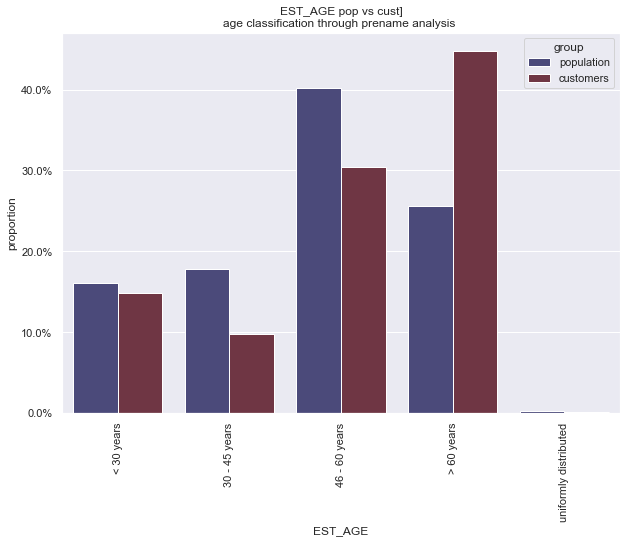

GENDER


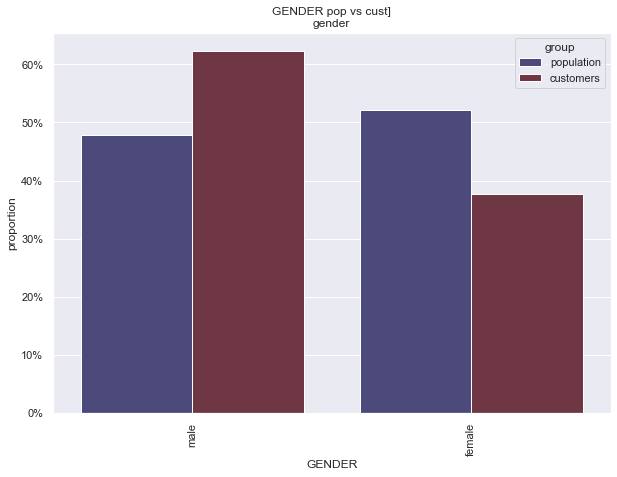

CUSTOMER_JOURNEY_TYPOLOGY


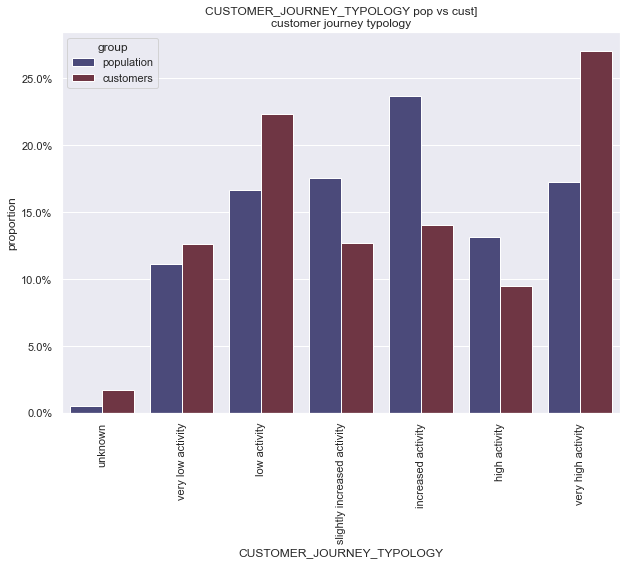

FIN_TYPETYP


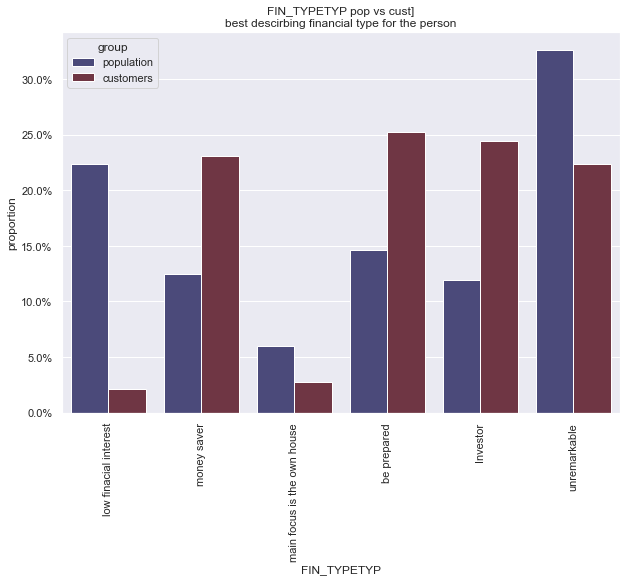

LIFESTAGE_SHORT


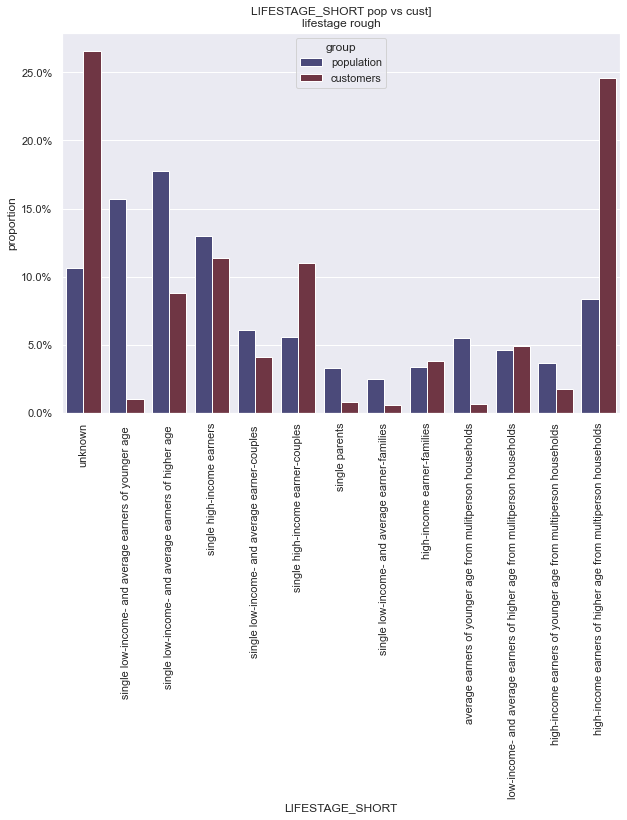

SOCIAL_STATUS_SHORT


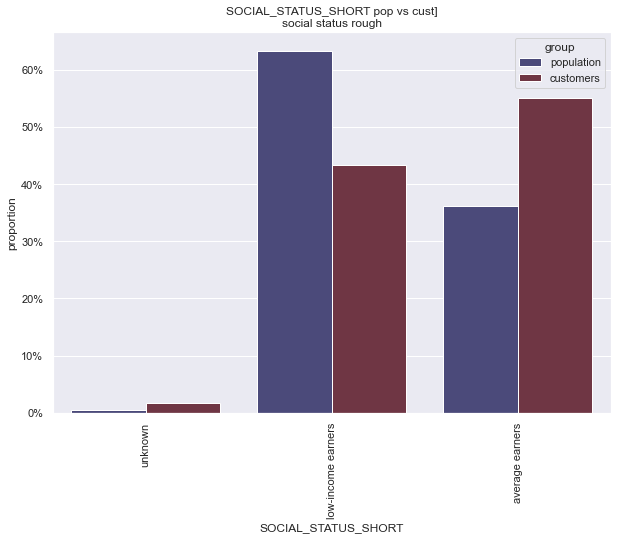

PERSON_YOUTH_MOVEMENT


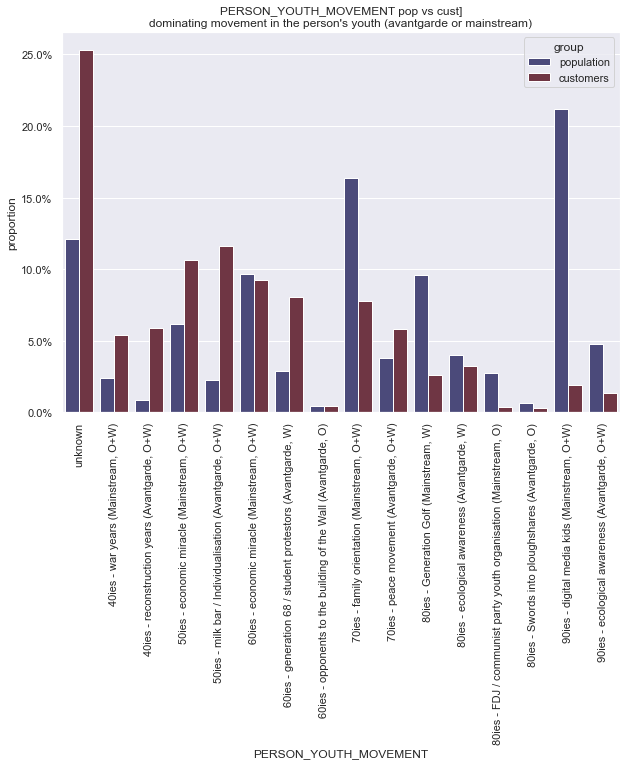

MIN_AFFIN_SOCIAL


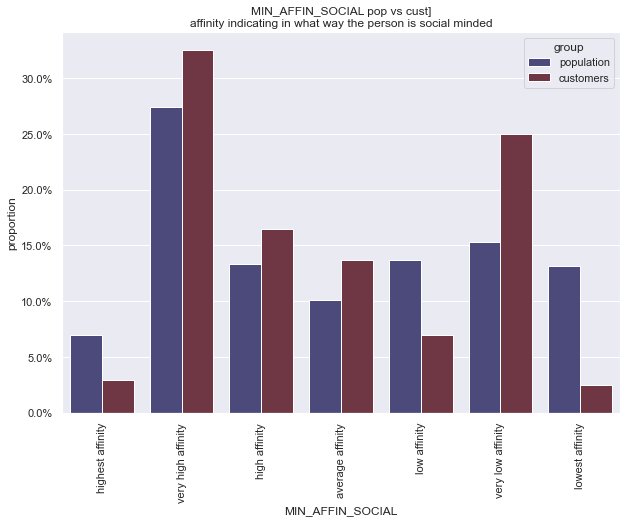

MIN_AFFIN_FAMILY


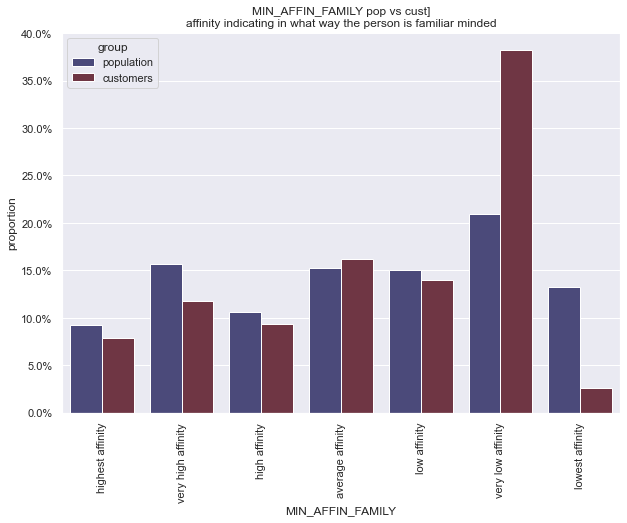

MIN_AFFIN_RELIGIOUS


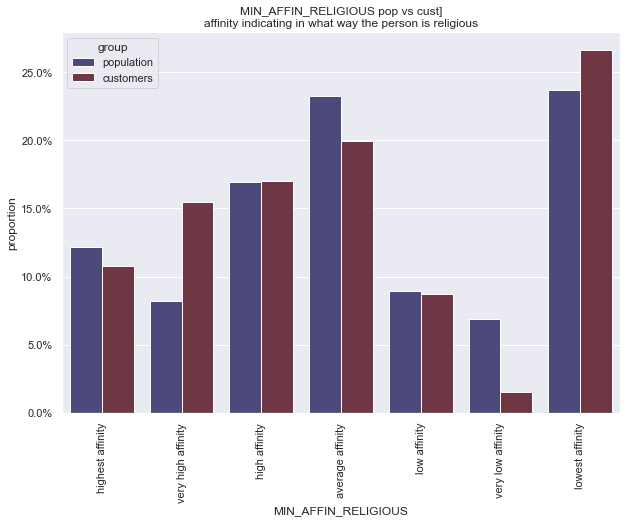

MIN_AFFIN_MATERIAL


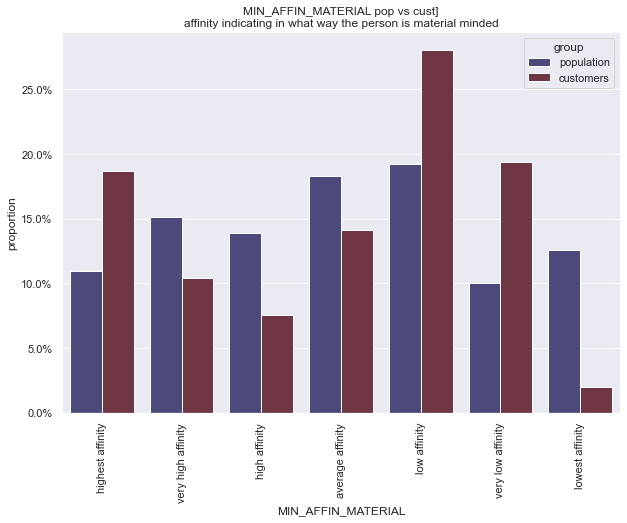

MIN_AFFIN_DREAMLY


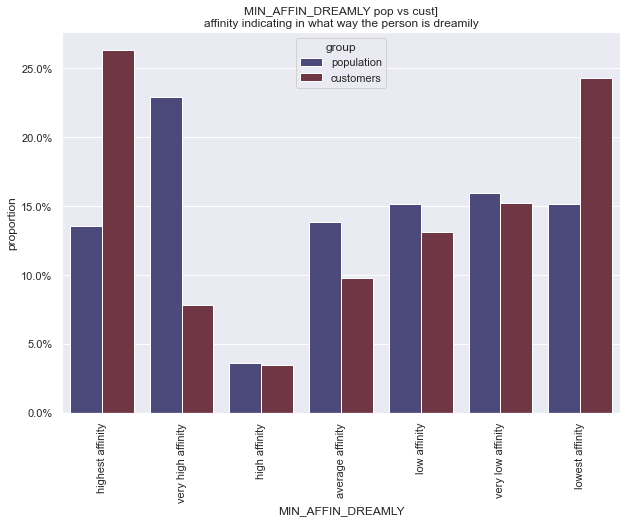

MIN_AFFIN_SENSUAL


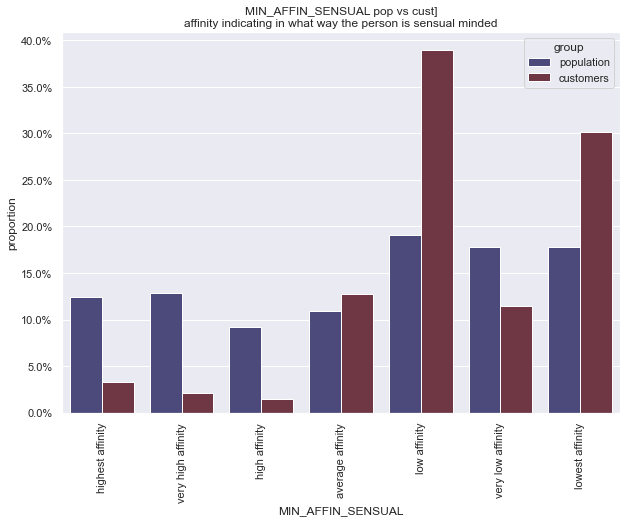

MIN_AFFIN_EVENTFUL


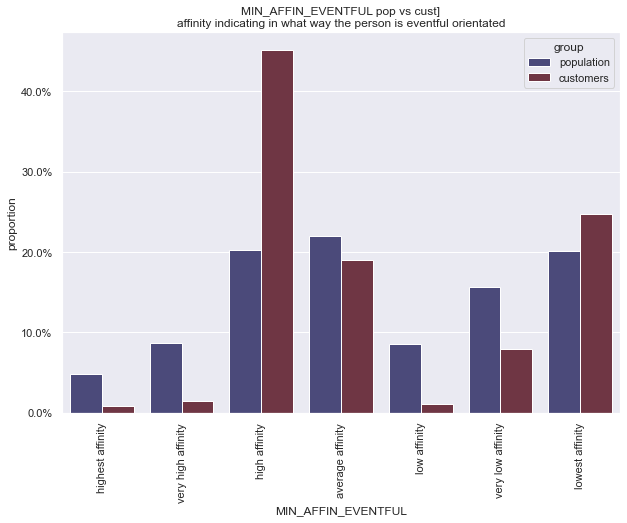

MIN_AFFIN_CULTURAL


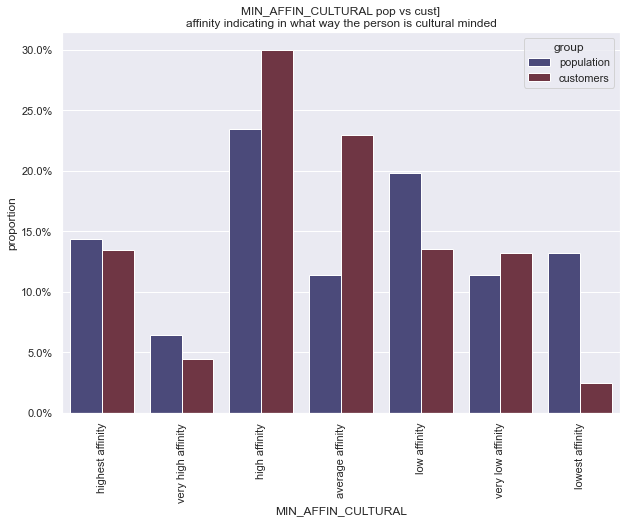

MIN_AFFIN_RATIONAL


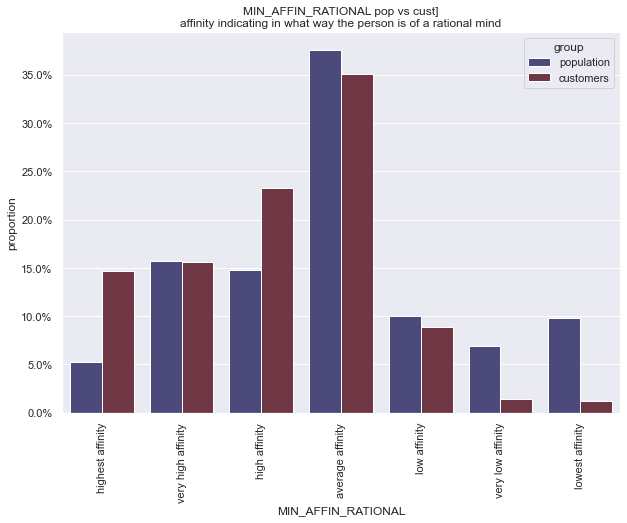

MIN_AFFIN_CRITICAL


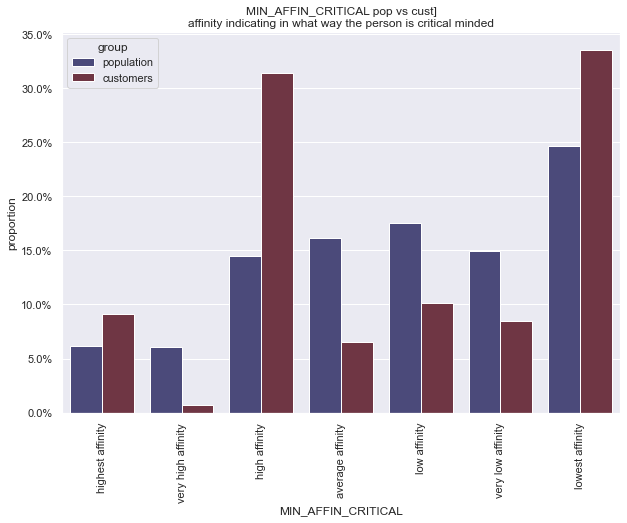

MIN_AFFIN_DOMINANT


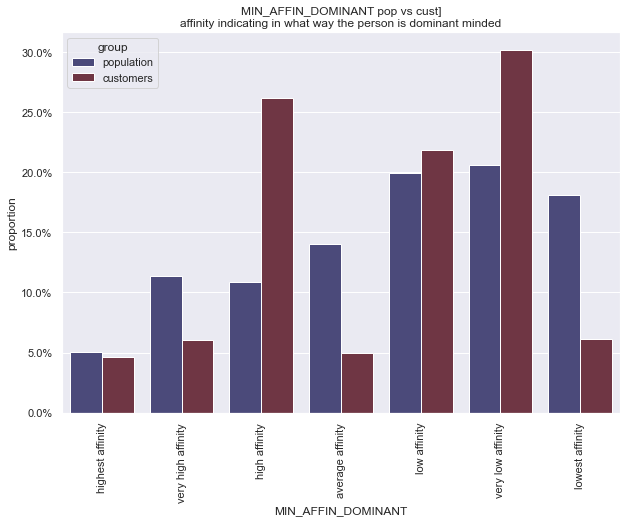

MIN_AFFIN_FIGHTFULL


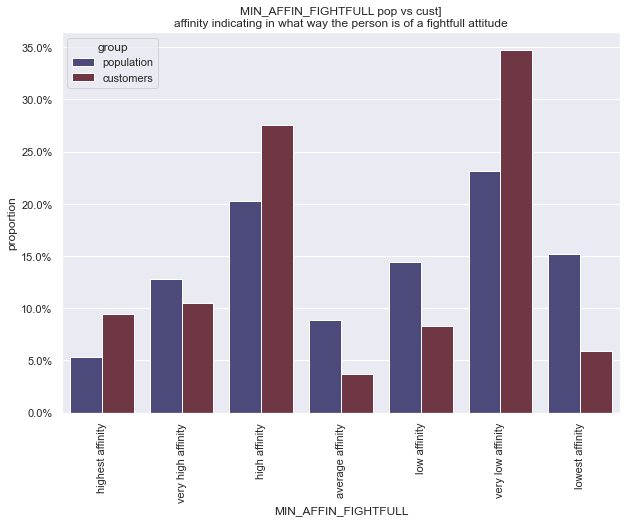

MIN_AFFIN_DUTYFULL_TRADITIONAL


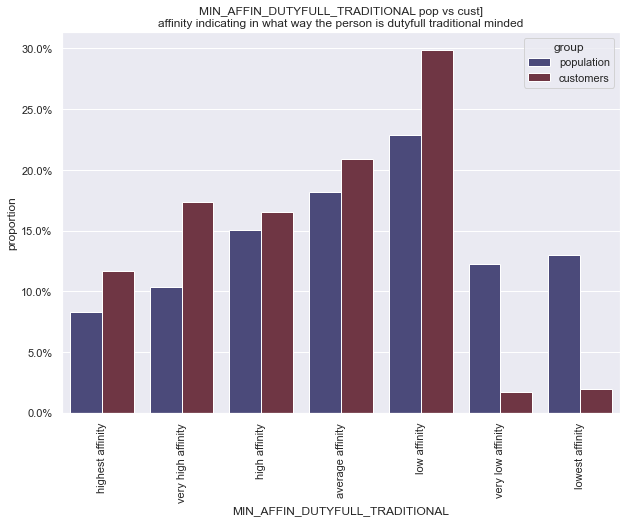

MIN_AFFIN_TRADITIONAL


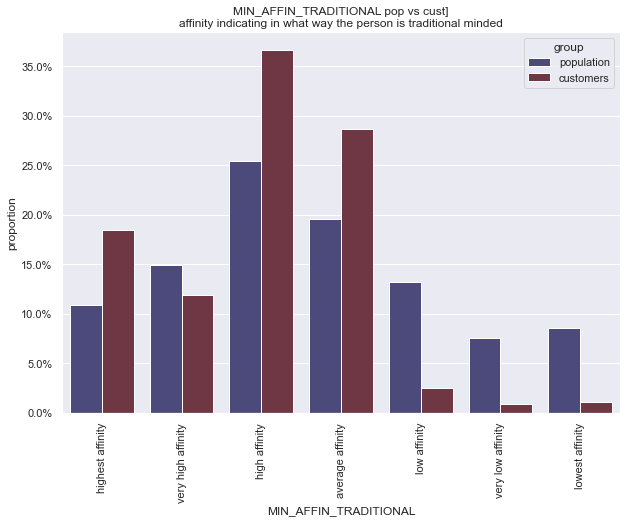

ACADEMIC_TITLE_HOLDER


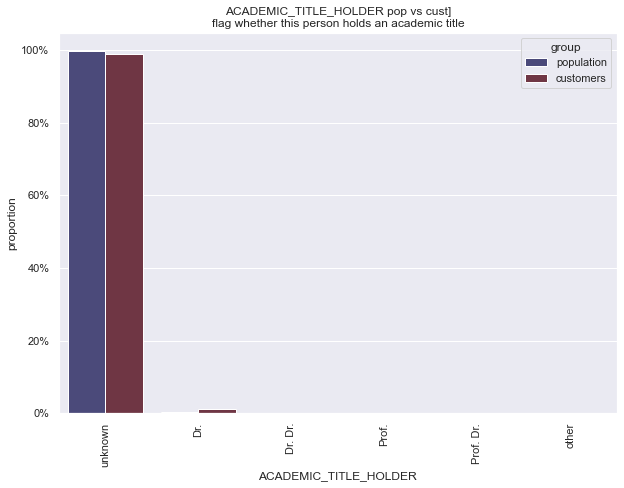

ENERGY_CONSUMPTION_MINDSET


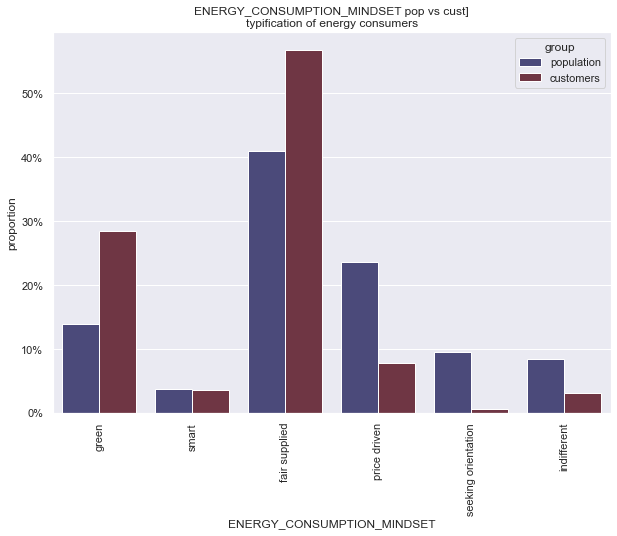

HOUSEHOLD_AGE


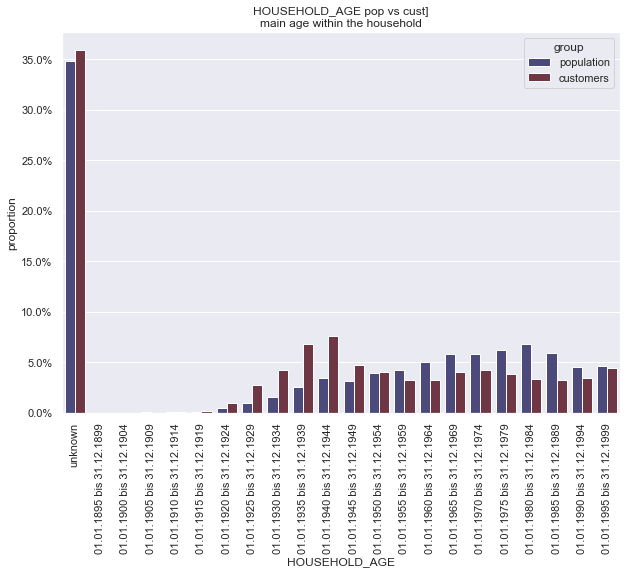

HOUSEHOLD_INCOME


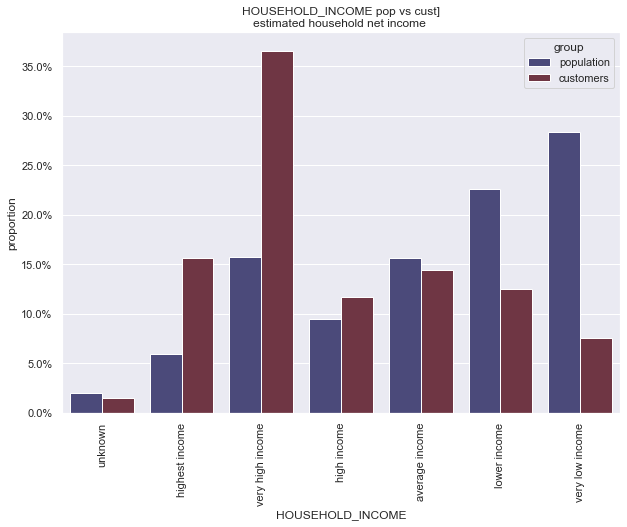

CONSUMPTION_TYPE


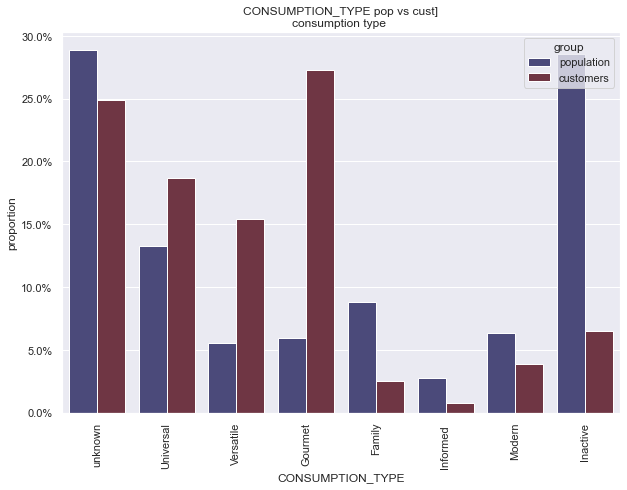

L24M_TRANSACTIONAL_ACTIVITY


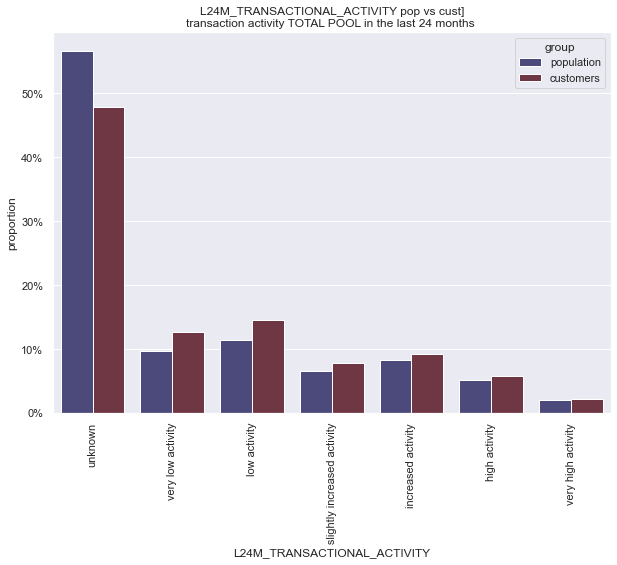

PERC_ONLINE_TRANSACTIONS


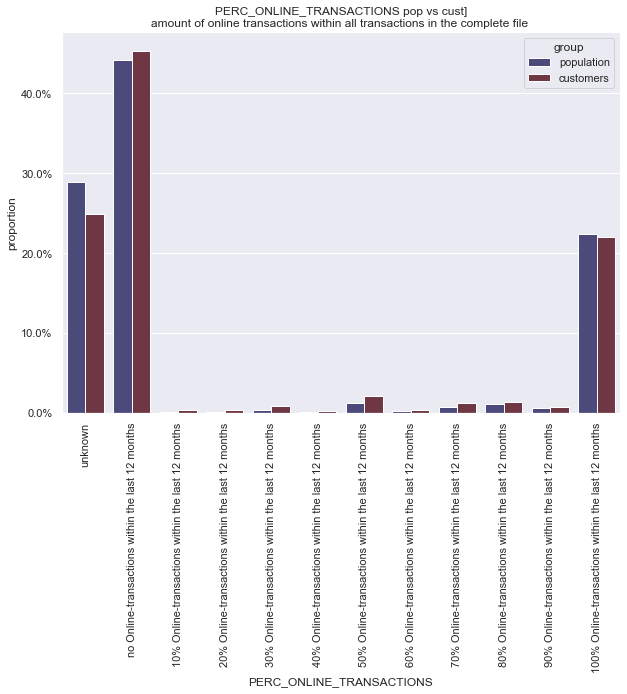

PERC_ONLINEBANK_TRANSACTIONS


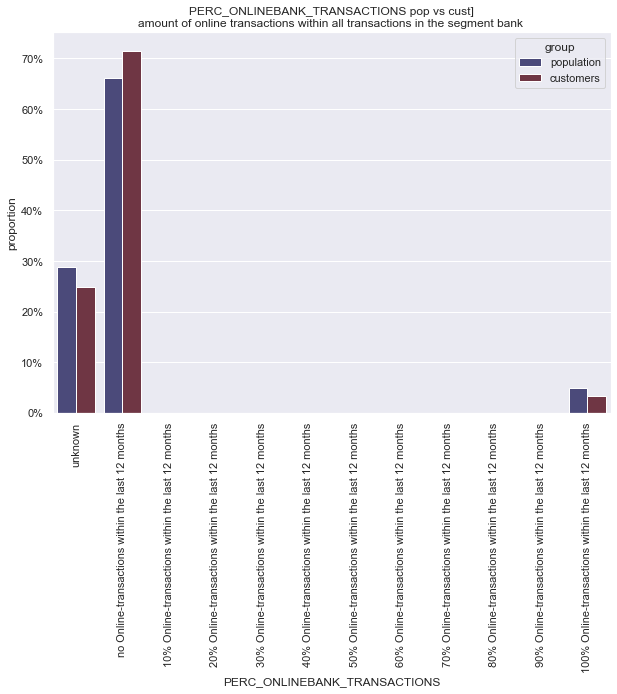

TYPE_OF_BUILDING


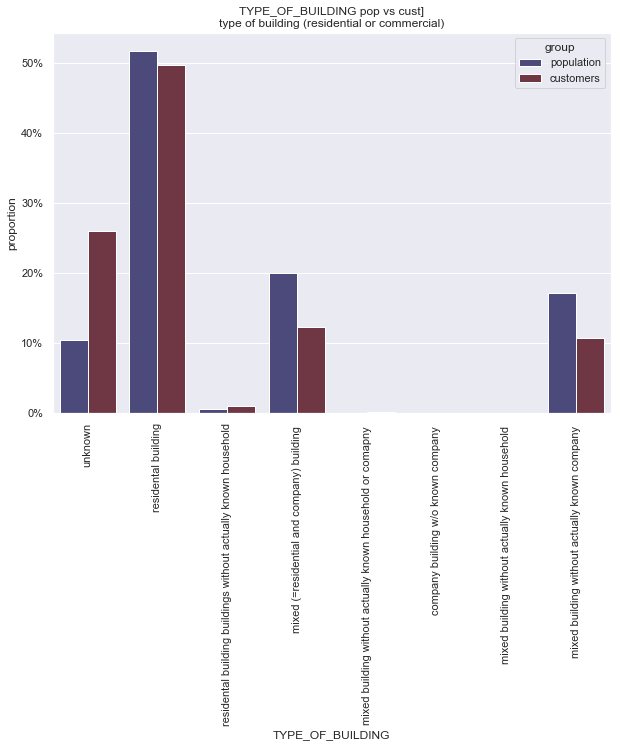

DISTANCE_POS


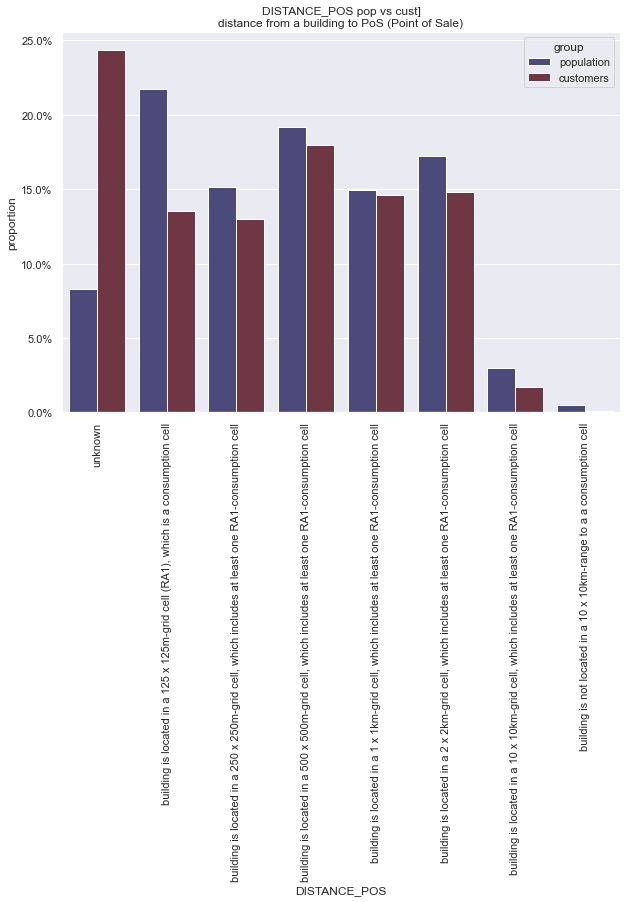

NEIGHBOURHOOD_CLASSIFICATION


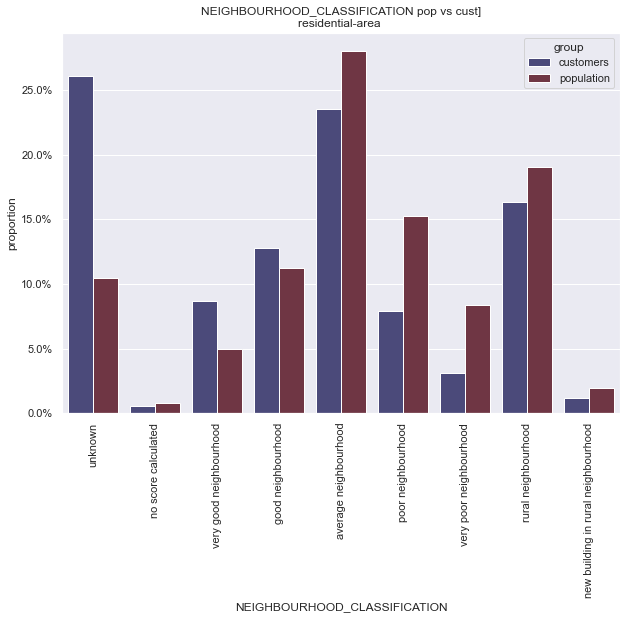

CAMEO_MICROCELL_CLASSIFICATION_SHORT


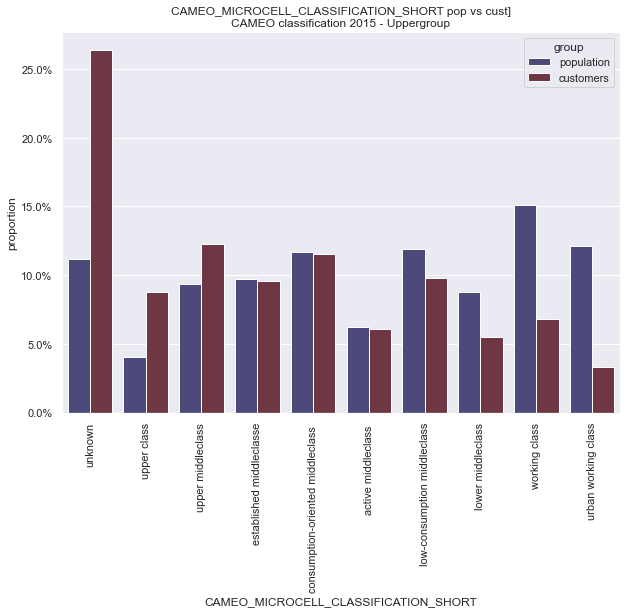

MICROCELL_N_BUILDINGS


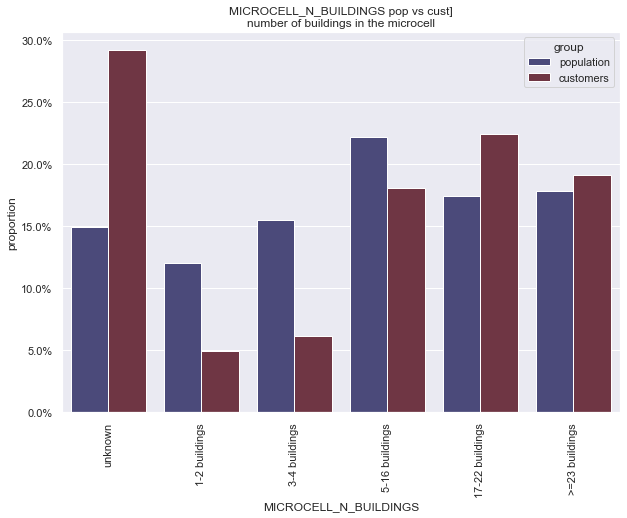

PERC_TOP_GERMAN_MANUFACTURERS


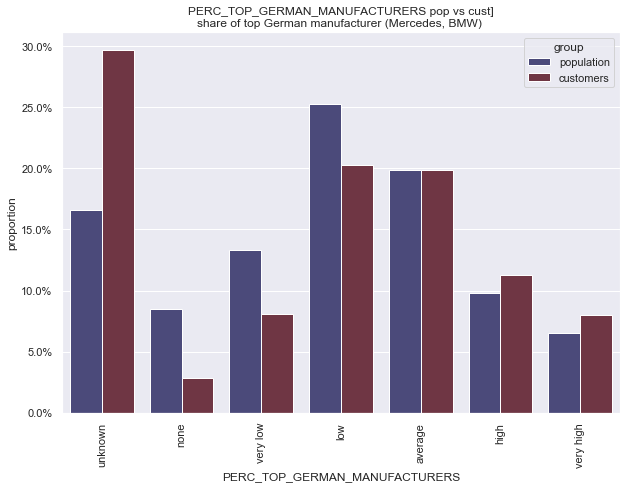

MICROCELL_MOST_COMMON_CAR_SEGMENT


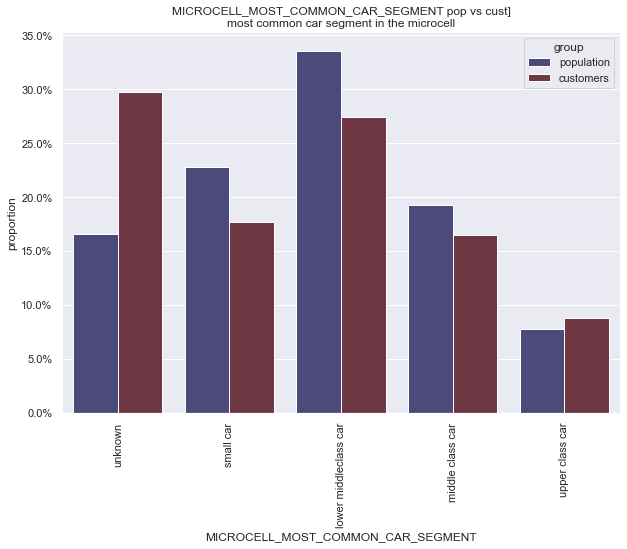

In [238]:
for i, feature_row in interesting_columns.iterrows():
    if feature_row["type"][:1] == "C":
        print(feature_row["new_column_name"])
        graph_cat_feature_pop_vs_customers(feature_row["new_column_name"])

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [13]:
def prepare_for_model(df):
    """
    prepares clean dataset for usage in a model
    """
    to_dummy_cols = list(
        set(features_summary[
            features_summary.to_dummy == 1
        ]["new_column_name"]) 
        &  set(df.columns)
    )
    df = pd.get_dummies(df, columns=to_dummy_cols)
    for col in ['LNR','D19_LETZTER_KAUF_BRANCHE', 'CAMEO_MICROCELL_CLASSIFICATION_DETAILED', "EINGEFUEGT_AM"]:
        if col in df.columns:
            df = df.drop(col, axis = 1)
    df = df.fillna(0).astype(int)
    return df

In [14]:
#https://stackoverflow.com/questions/39512260/calculating-gini-coefficient-in-python-numpy
def gini(x):
    "calculates gini coeficient for an array"
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [69]:
azdias["iscustomer"] = 0
customers["iscustomer"] = 1
consolidated_demographics = pd.concat([
    azdias, 
    customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP'], axis=1)
], axis=0)
scaler = MinMaxScaler()
consolidated_demographics_transformed = prepare_for_model(consolidated_demographics)
consolidated_demographics_transformed = scaler.fit_transform(
    consolidated_demographics_transformed.drop(["iscustomer"], axis=1)
)

In [70]:
gini_coefficients = []
for k in range(3, 15, 1):
    iscustomer = consolidated_demographics[["iscustomer"]]
    kmeans = KMeans(n_clusters=k).fit(consolidated_demographics_transformed)
    iscustomer["group"] = kmeans.labels_
    iscustomer_group = iscustomer.groupby("group").agg({"iscustomer":sum})
    gini_coefficients.append(gini(iscustomer_group["iscustomer"].values))

<ipython-input-70-b394e4b794e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iscustomer["group"] = kmeans.labels_
<ipython-input-70-b394e4b794e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iscustomer["group"] = kmeans.labels_
<ipython-input-70-b394e4b794e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

<AxesSubplot:>

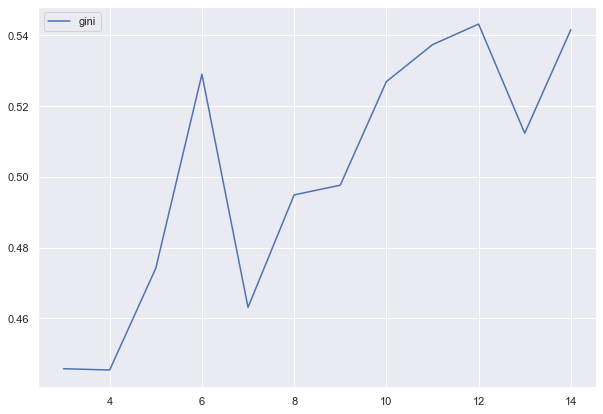

In [75]:
pd.DataFrame({"gini": gini_coefficients},index=range(3,15,1)).plot()

In [102]:
kmeans = KMeans(n_clusters=12).fit(consolidated_demographics_transformed)

In [103]:
consolidated_demographics["group"] = kmeans.labels_
(consolidated_demographics.groupby("group").agg({"iscustomer":sum})/consolidated_demographics["iscustomer"].sum()).sort_values("iscustomer")

,iscustomer
group,
11,0.002880
10,0.005562
5,0.012585
9,0.024357
6,0.031959
0,0.057557
3,0.070372
7,0.076075
4,0.089824


In [74]:
# weight of every group
consolidated_demographics["group"].value_counts()/consolidated_demographics.shape[0]

4     0.111595
8     0.109201
10    0.107615
9     0.100604
2     0.098356
6     0.094845
1     0.090778
7     0.088617
3     0.087745
11    0.050104
0     0.033467
5     0.027074
Name: group, dtype: float64

In [104]:
consolidated_demographics["group2"] = consolidated_demographics["group"].apply(lambda g: "LIKELYTOBECUSTOMER" if g in [1,4,2,8] else "NONCUSTOMER" if g in[9,11,5,10] else "MEDIUM")

In [77]:
def graph_feature_distribution_by_group_on_consolidate(feature):
    description, feature_meaning = get_values_for_feature(feature)

    graph_data = consolidated_demographics.groupby("group2")[feature].value_counts().groupby(level=0).apply(lambda x: x/x.sum()).to_frame().loc[["LIKELYTOBECUSTOMER","NONCUSTOMER"]]
    graph_data.columns = ["proportion"]
    graph_data.reset_index(inplace=True)
    graph_data.sort_values(by=feature, inplace=True)

    graph_data[feature] = graph_data[feature].map(feature_meaning)
    graph_data= graph_data.groupby(["group2", feature], as_index=False, sort=False).agg({"proportion":sum})


    plt.xticks(rotation=90)
    sns.set_palette(sns.color_palette("icefire", 2))
    ax = sns.barplot(x=feature, y="proportion", hue="group2", data=graph_data, ci=None, hue_order=["LIKELYTOBECUSTOMER","NONCUSTOMER"])
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_title("{}\n{}".format(feature, description))
    plt.show()

EST_AGE


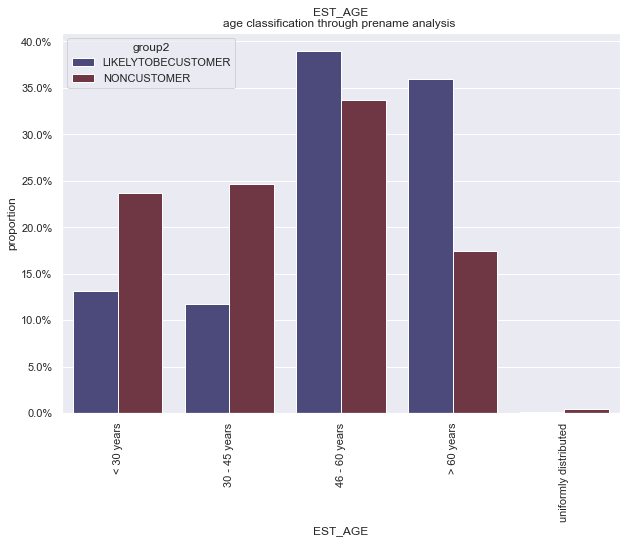

GENDER


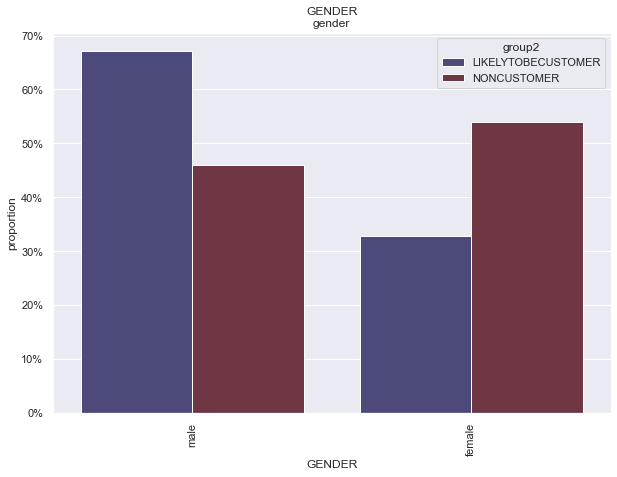

CUSTOMER_JOURNEY_TYPOLOGY


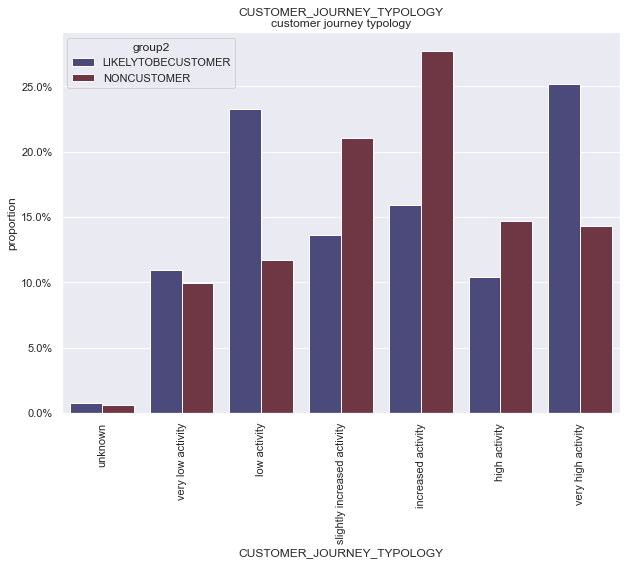

FIN_TYPETYP


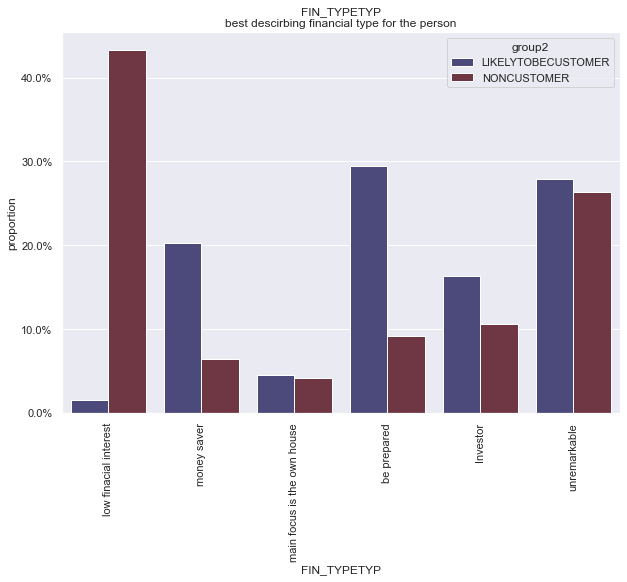

LIFESTAGE_SHORT


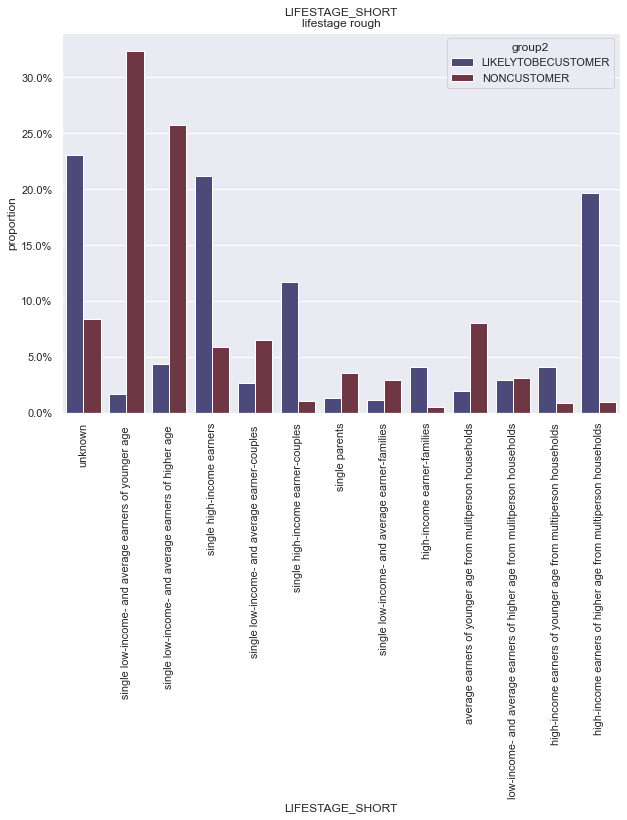

SOCIAL_STATUS_SHORT


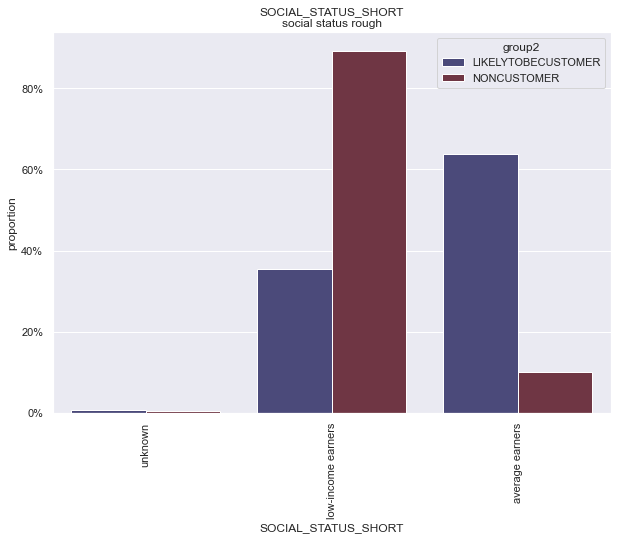

PERSON_YOUTH_MOVEMENT


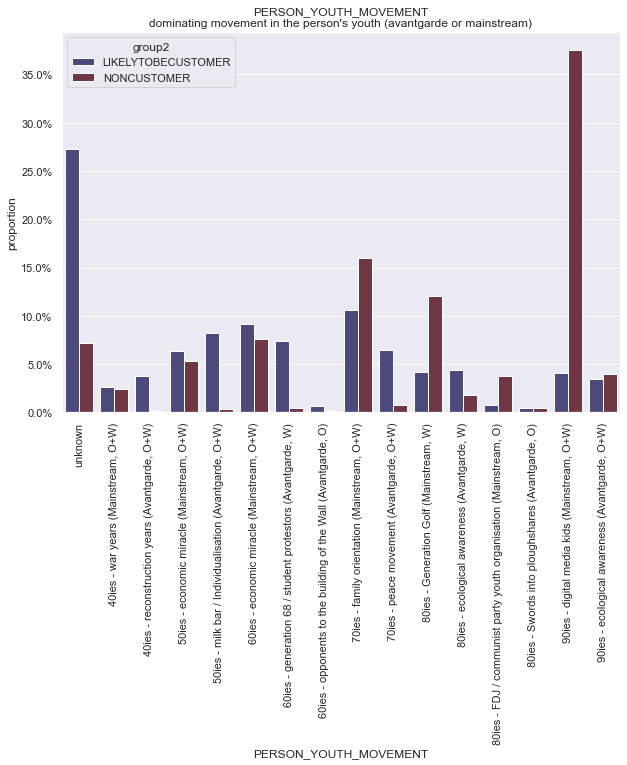

MIN_AFFIN_SOCIAL


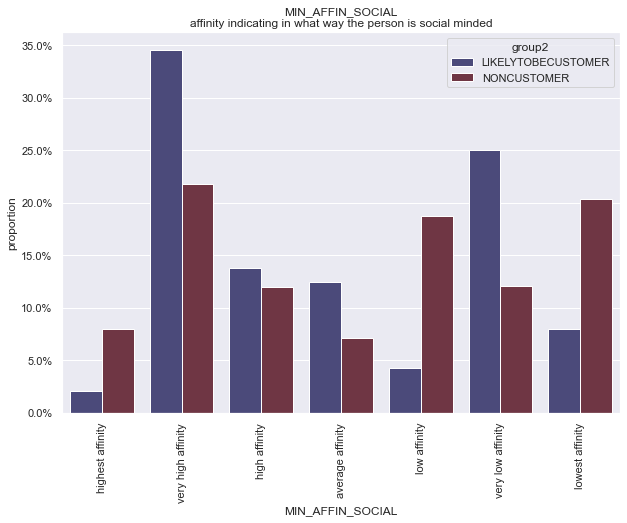

MIN_AFFIN_FAMILY


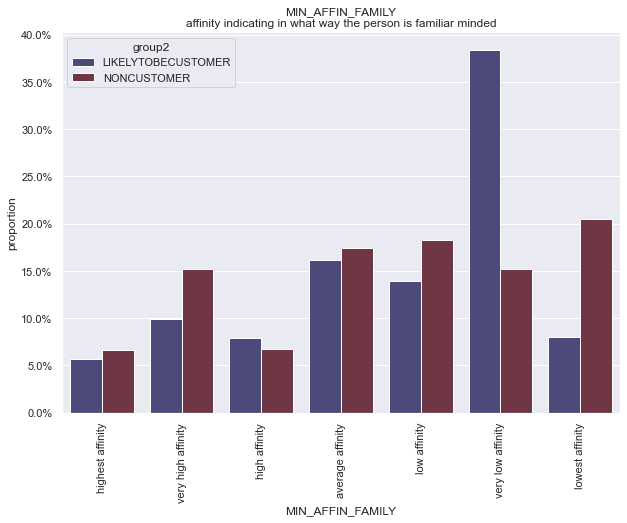

MIN_AFFIN_RELIGIOUS


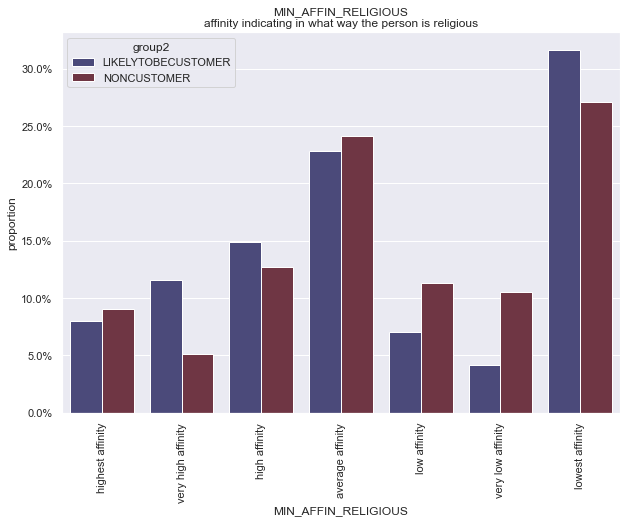

MIN_AFFIN_MATERIAL


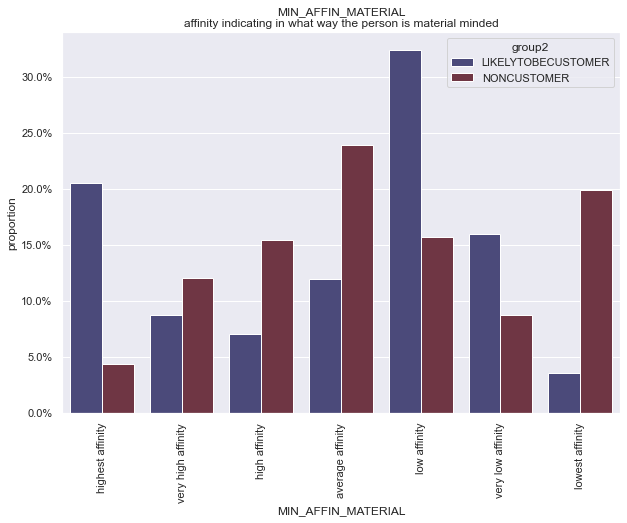

MIN_AFFIN_DREAMLY


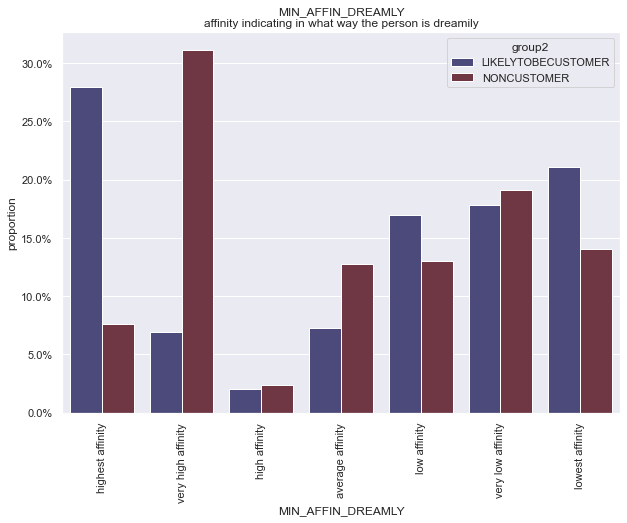

MIN_AFFIN_SENSUAL


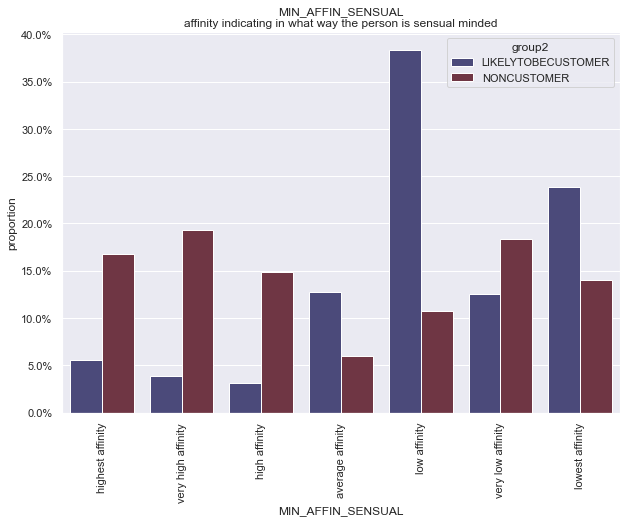

MIN_AFFIN_EVENTFUL


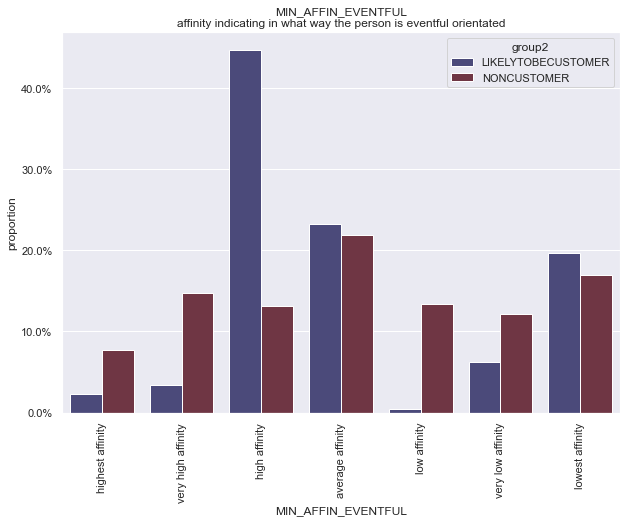

MIN_AFFIN_CULTURAL


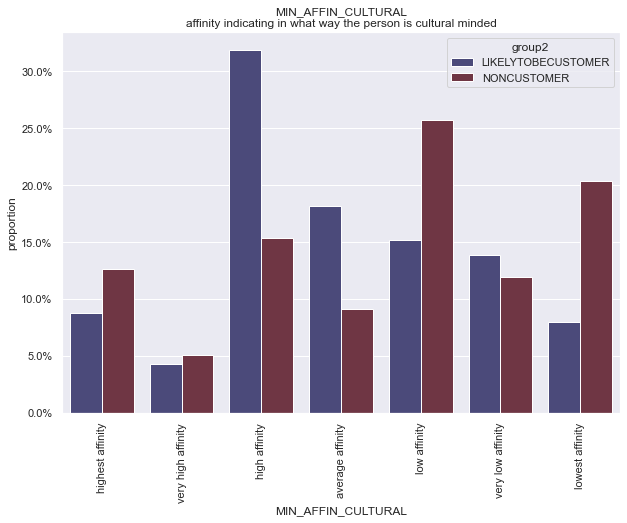

MIN_AFFIN_RATIONAL


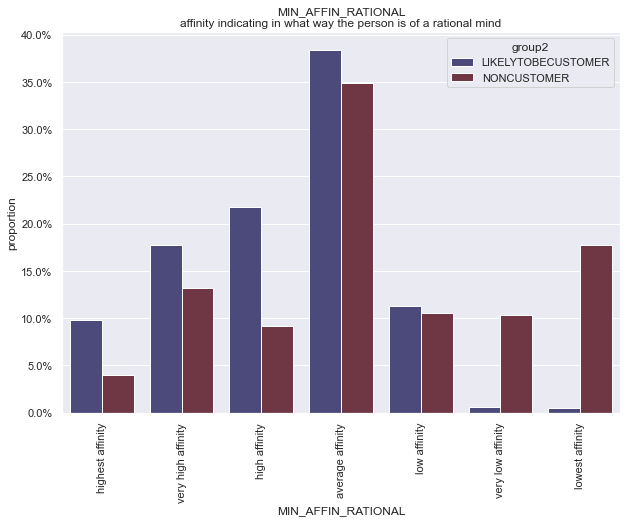

MIN_AFFIN_CRITICAL


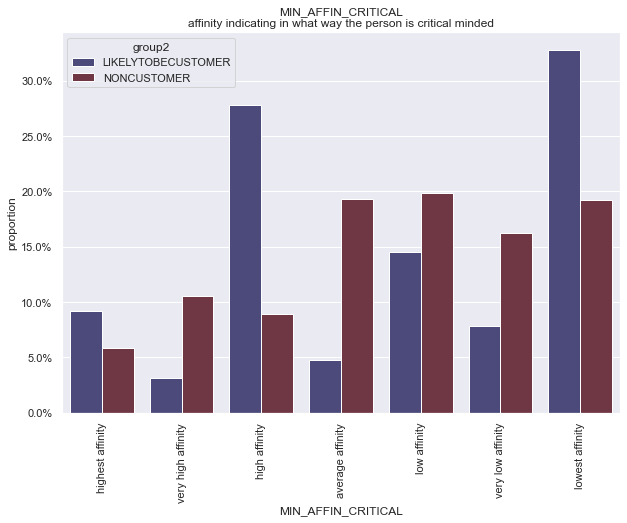

MIN_AFFIN_DOMINANT


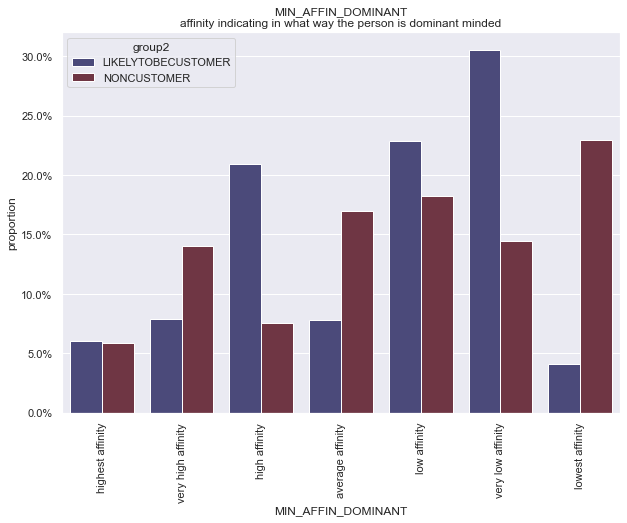

MIN_AFFIN_FIGHTFULL


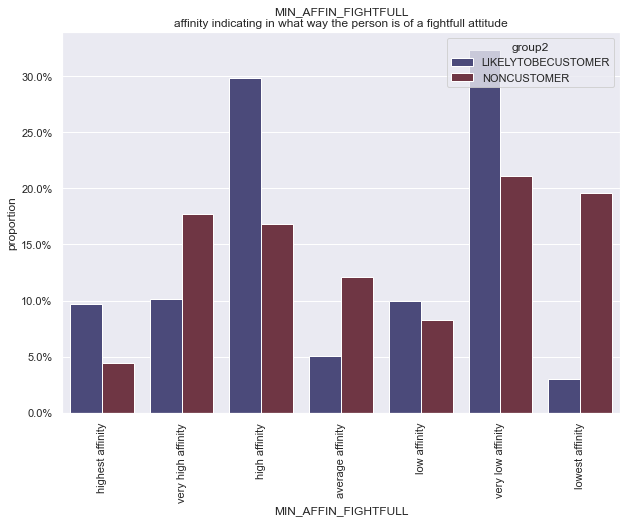

MIN_AFFIN_DUTYFULL_TRADITIONAL


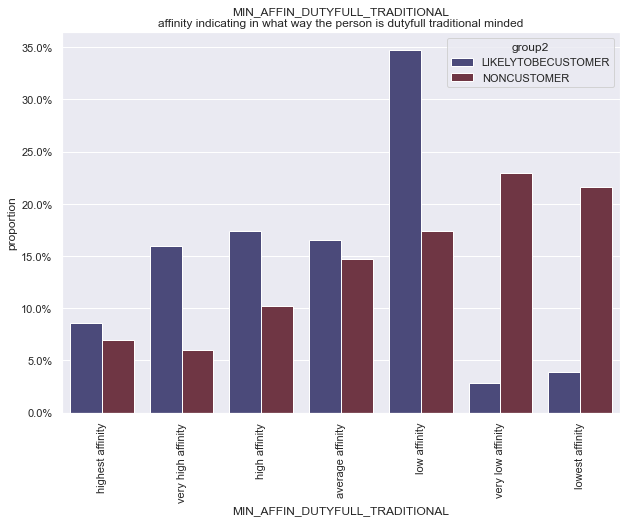

MIN_AFFIN_TRADITIONAL


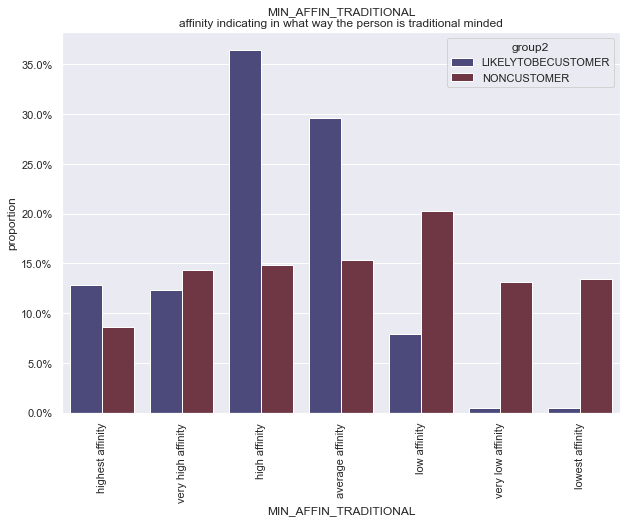

ACADEMIC_TITLE_HOLDER


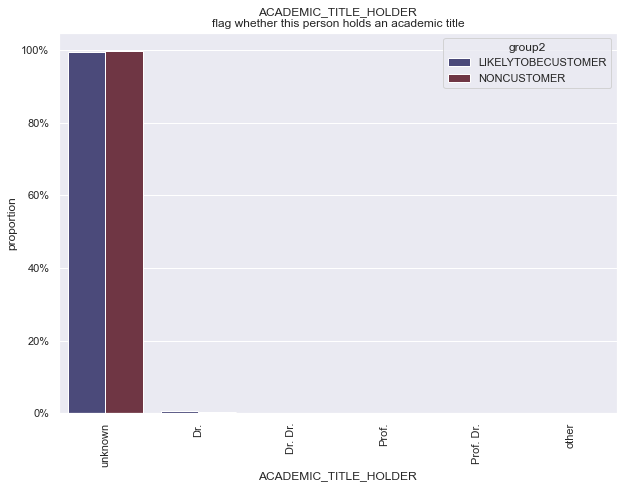

ENERGY_CONSUMPTION_MINDSET


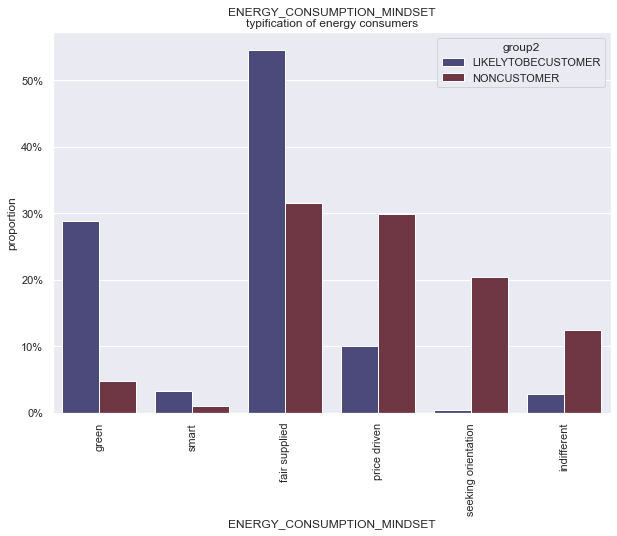

HOUSEHOLD_AGE


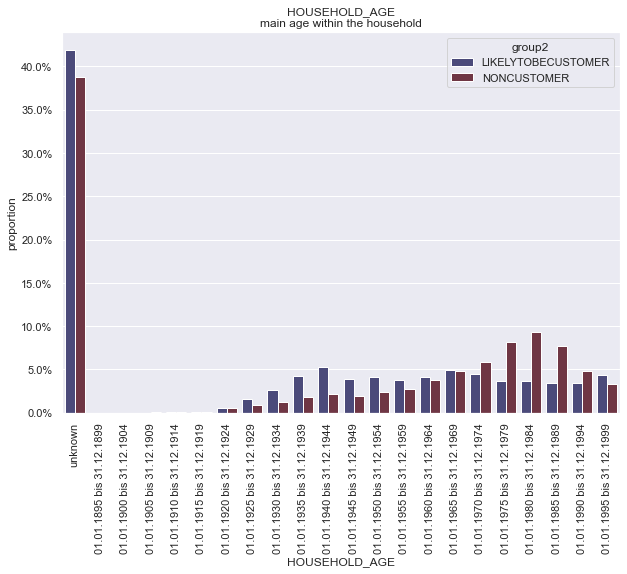

HOUSEHOLD_INCOME


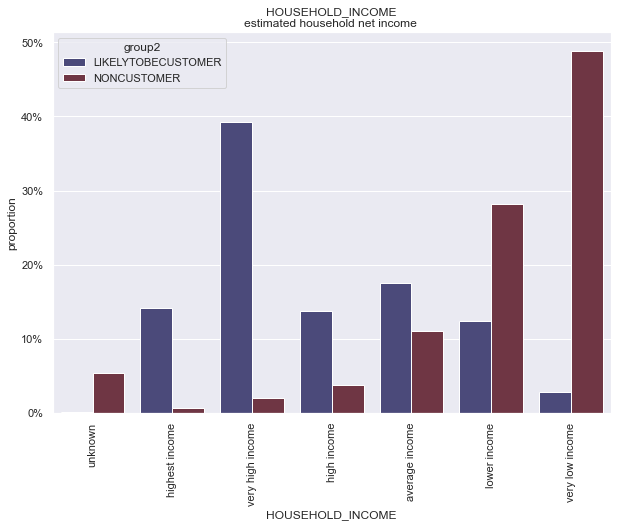

CONSUMPTION_TYPE


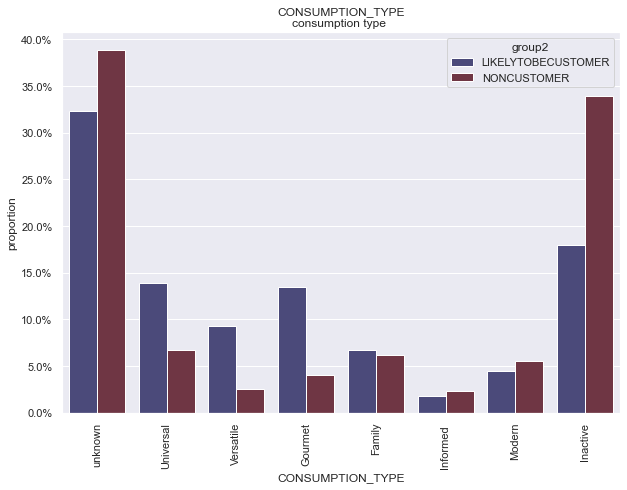

L24M_TRANSACTIONAL_ACTIVITY


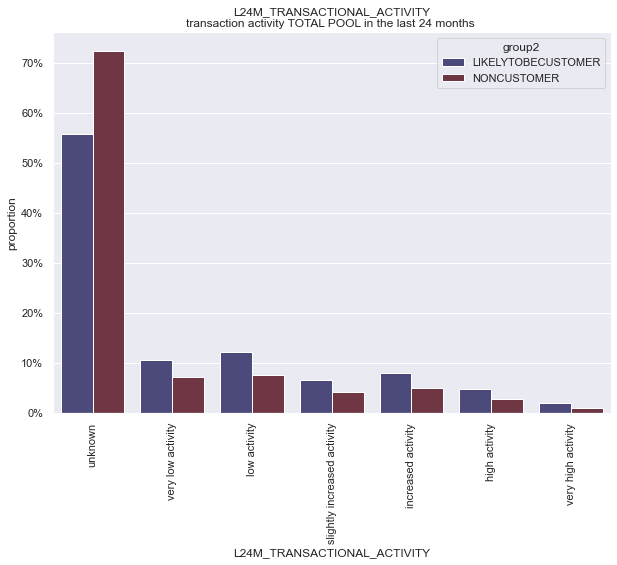

PERC_ONLINE_TRANSACTIONS


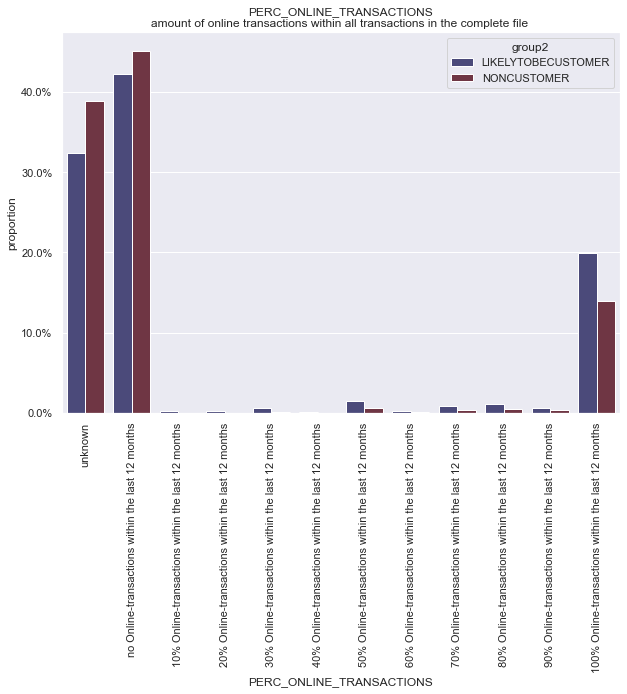

PERC_ONLINEBANK_TRANSACTIONS


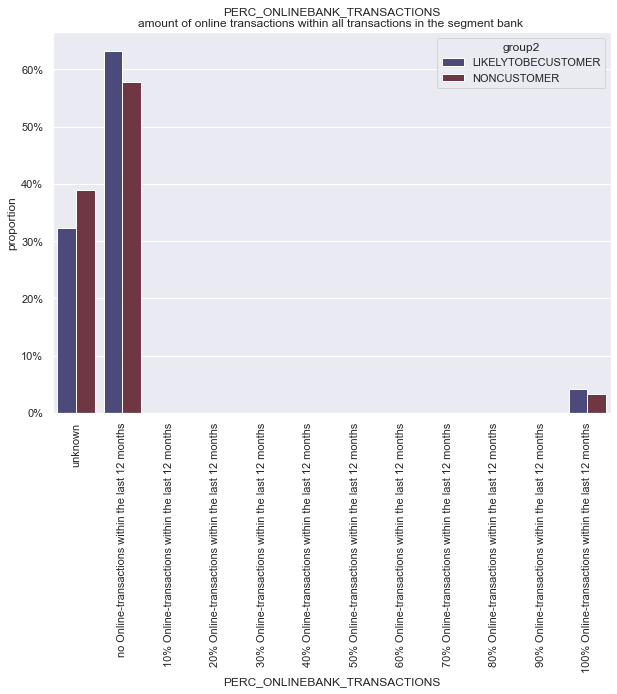

TYPE_OF_BUILDING


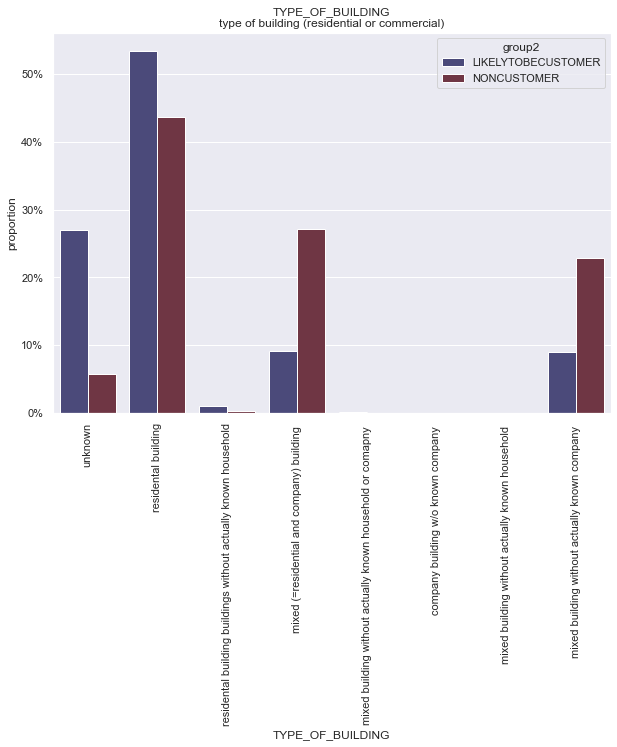

DISTANCE_POS


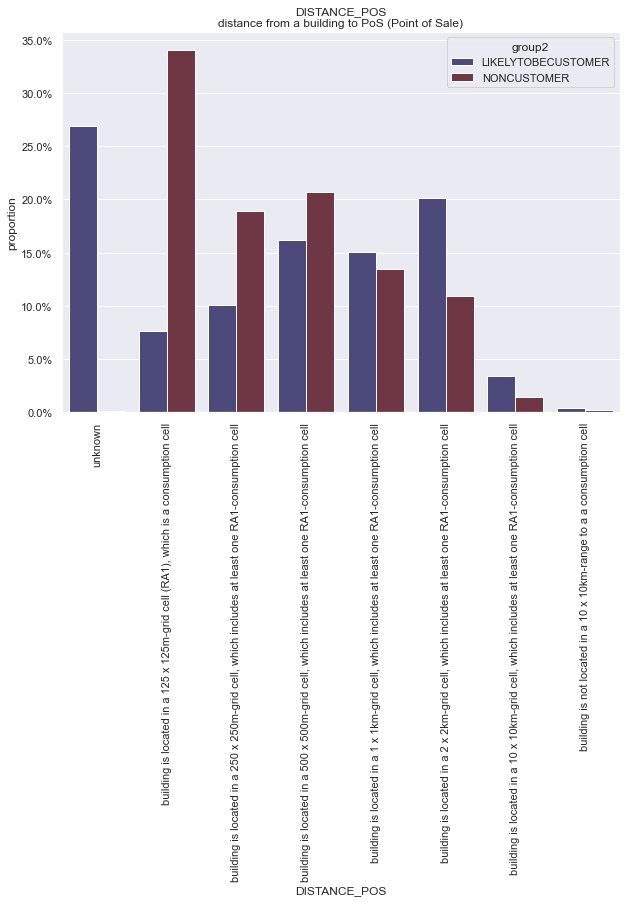

NEIGHBOURHOOD_CLASSIFICATION


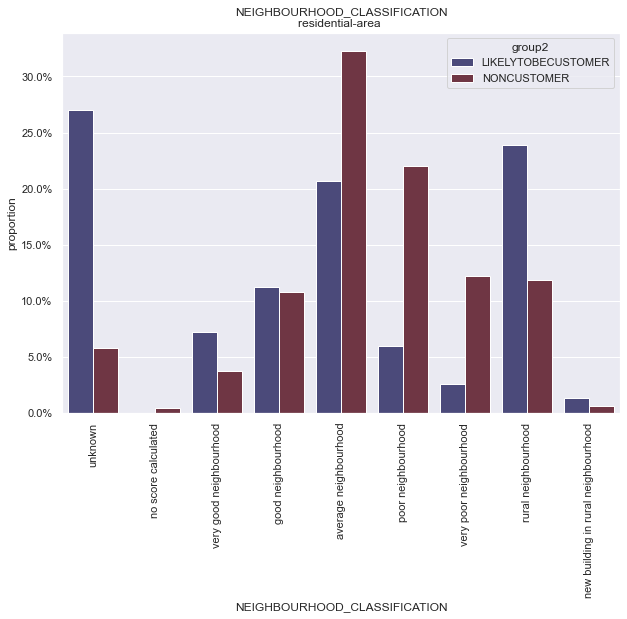

CAMEO_MICROCELL_CLASSIFICATION_SHORT


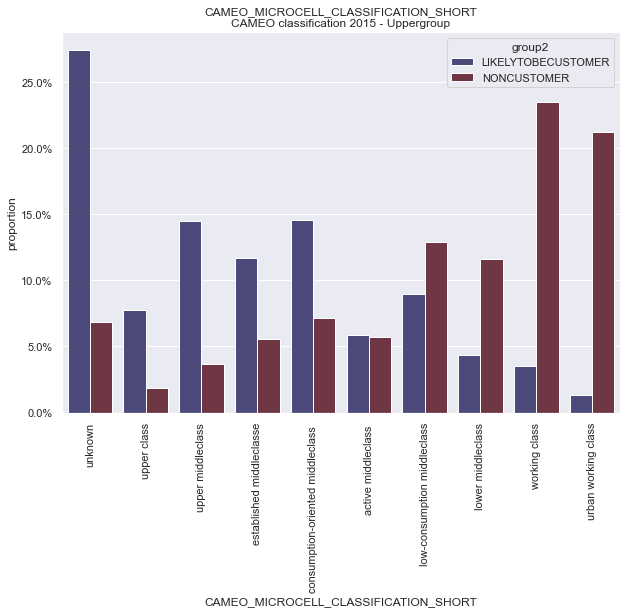

MICROCELL_N_BUILDINGS


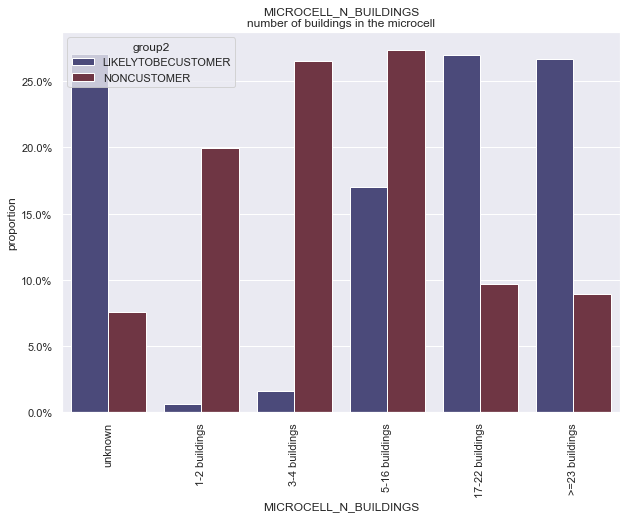

PERC_TOP_GERMAN_MANUFACTURERS


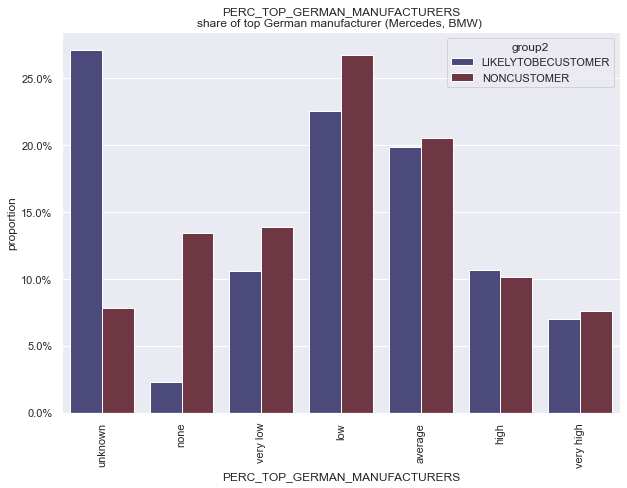

MICROCELL_MOST_COMMON_CAR_SEGMENT


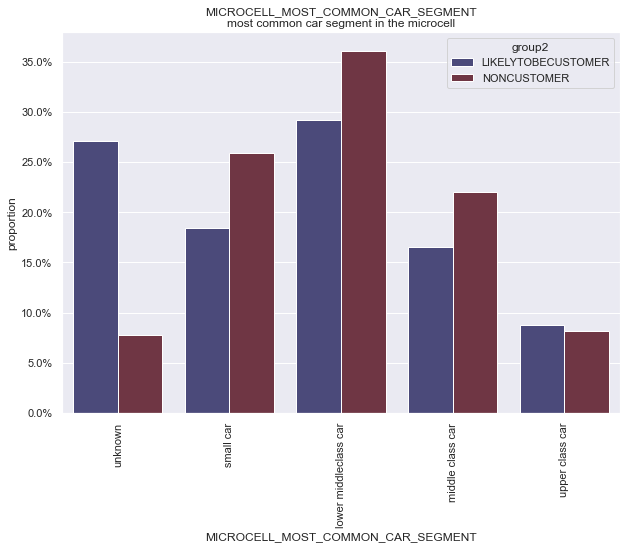

In [78]:
for i, feature_row in interesting_columns.iterrows():
    if feature_row["type"][:1] == "C" and feature_row["new_column_name"] in consolidated_demographics.columns:
        print(feature_row["new_column_name"])
        graph_feature_distribution_by_group_on_consolidate(feature_row["new_column_name"])

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [79]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
nan_values_per_column = mailout_train.isnull().mean()
columns_with_to_many_missing_data = list(nan_values_per_column[nan_values_per_column > 0.5].index)
clean_df(mailout_train, extra_cols_to_drop=columns_with_to_many_missing_data, drop_columns_not_in_feature_excel=False)

C:\Users\arata\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [80]:
mailout_train = prepare_for_model(mailout_train)

In [81]:
mailout_train.head()

,AKT_DAT_KL,HOUSEHOLD_AGE,ALTERSKATEGORIE_FEIN,N_HOUSEHOLDS_IN_BUILDING,N_ACADEMIC_PEOPLE_BUILDING,ANZ_KINDER,N_PEOPLE_HOUSEHOLD,ANZ_STATISTISCHE_HAUSHALTE,N_ACADEMIC_PEOPLE_HOUSEHOLD,POSTCODE_DIST_TO_METROPOLE,CAMEO_MICROCELL_CLASSIFICATION_SHORT,CAMEO_INTL_2015,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,PERC_ONLINEBANK_TRANSACTIONS,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,L12M_TRANSACTIONAL_ACTIVITY,L24M_TRANSACTIONAL_ACTIVITY,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,PERC_ONLINE_TRANSACTIONS,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,PERC_ONLINEMAIL_TRANSACTIONS,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,POSTCODE_INHABITANTS_SQKM,EXTSEL992,FIN_TYPE_INVESTOR,FIN_TYPE_HOMEFOCUSED,FIN_TYPE_MINIMALIST,FIN_TYPE_SPARER,FIN_TYPE_UNREMARKABLE,FIN_TYPE_PRECAUTIOUS,FIRMENDICHTE,BIRTHYEAR,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HOUSEHOLD_INCOME,POSTCODE_DIST_TO_CITYCENTRE,MICROCELL_PERC_CAR_OWNERS_UNDER_31,MICROCELL_PERC_CAR_OWNERS_UNDER_45,MICROCELL_PERC_CAR_OWNERS_UNDER_60,MICROCELL_PERC_CAR_OWNERS_OVER_60,MICROCELL_PERC_TRAILERS,MICROCELL_2_MEMBER_FAMILIES,MICROCELL_5_MEMBER_FAMILIES,MICROCELL_10_MEMBER_FAMILIES,MICROCELL_OVER10_MEMBER_FAMILIES,CARS_PER_HOUSEHOLD,MOST_COMMON_BUILDING_MICROCELL,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,MICROCELL_N_BUILDINGS,PERC_TOP_GERMAN_MANUFACTURERS,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,MICROCELL_MOST_COMMON_DRIVER_AGE,MICROCELL_MOST_COMMON_CAR_AGE,MICROCELL_MOST_COMMON_CAR_SEGMENT,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_

In [82]:
mailout_train["RESPONSE"].value_counts() / mailout_train.shape[0]

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

In [105]:
mailout_train.shape

(42962, 425)

In [83]:
model = xgb.XGBClassifier(subsample=0.65, n_estimators=500, learning_rate=0.004, gamma=2)
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', model)
])


bcv = BayesSearchCV(
    estimator = pipeline,
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True
    ),
    search_spaces = {
        'clf__scale_pos_weight':Real(40,80),
        'clf__max_depth': Integer(2, 5),
        'clf__min_child_weight': Integer(4,10),
        'clf__colsample_bytree': Real(0.5,1, 'uniform')
    },    
    scoring = 'roc_auc',
    n_jobs = -1,
    n_iter = 15,
    refit = True,
    verbose=True
)

In [84]:
bcv.fit(mailout_train.drop(["RESPONSE"], axis=1), mailout_train["RESPONSE"].values)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\arata\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
              estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       gamma=2, gpu_id=None,
                                                       importance_type='gain',
                                                       interaction_constraints=None,
                                                       learning_rate=0.004,
                                                       max_delta_ste...
              search_spaces={'clf__colsa

In [87]:
mean_score = bcv.cv_results_["mean_test_score"][bcv.best_index_]
std_score = bcv.cv_results_["std_test_score"][bcv.best_index_]

bcv.best_params_, mean_score, std_score

print(f"Best parameters: {bcv.best_params_}")
print(f"Mean CV score: {mean_score: .6f}")
print(f"Standard deviation of CV score: {std_score: .6f}")

Best parameters: OrderedDict([('clf__colsample_bytree', 0.9538787548328516), ('clf__max_depth', 4), ('clf__min_child_weight', 5), ('clf__scale_pos_weight', 64.19778036588166)])
Mean CV score:  0.772314
Standard deviation of CV score:  0.028927


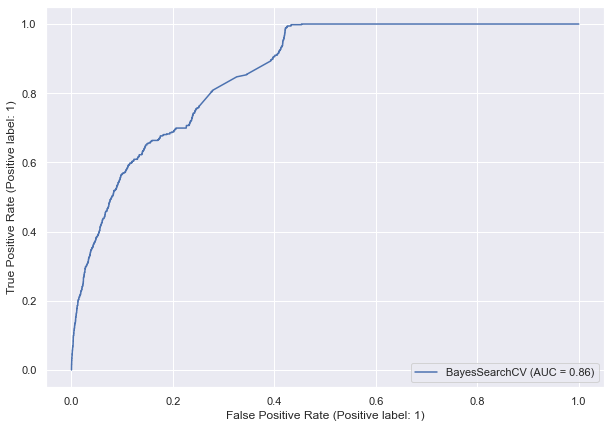

In [90]:
plot_roc_curve(bcv, mailout_train.drop(["RESPONSE"], axis=1), mailout_train["RESPONSE"])

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [91]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
clean_df(mailout_test, extra_cols_to_drop=columns_with_to_many_missing_data, drop_columns_not_in_feature_excel=False)
mailout_test_prepared = prepare_for_model(mailout_test)

C:\Users\arata\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [92]:
pred_test = bcv.predict_proba(mailout_test_prepared)[:,1]

In [93]:
confusion_matrix(mailout_train["RESPONSE"], bcv.predict(mailout_train.drop(["RESPONSE"], axis=1)))

array([[32596,  9834],
       [  155,   377]], dtype=int64)

In [96]:
mailout_test_2 = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')[["LNR"]]

C:\Users\arata\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [98]:
mailout_test_2["RESPONSE"] = pred_test

In [100]:
mailout_test_2.to_csv("kaggle_response_rest.csv", index=False)

In [101]:
mailout_test_2.head()

,LNR,RESPONSE
0,1754,0.677339
1,1770,0.668664
2,1465,0.162222
3,1470,0.221121
4,1478,0.197574
